In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from pprint import pprint
from pyspark.sql import SparkSession

# New API
spark_session = SparkSession\
        .builder\
        .master("spark://192.168.2.87:7077") \
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.shuffle.service.enabled", True)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores",4)\
        .appName("read_weather_data")\
        .getOrCreate()

# Old API (RDD)
spark_context = spark_session.sparkContext

In [9]:
data_frame = spark_session.read\
    .option("header", "true")\
    .csv('hdfs://192.168.2.87:9000/weather.csv')\
    .cache()

In [10]:
spark_context.uiWebUrl

'http://192.168.2.87:4040'

In [11]:
# Count the files:
#$ find -type f | wc -l
# 2546

# Count the lines in 1 file:
# $cat 10224099999.csv | wc -l
# 8756

# Count the CSV rows:
data_frame.count()

# Maximum rows in excel: 1,048,576
# https://support.office.com/en-us/article/excel-specifications-and-limits-1672b34d-7043-467e-8e27-269d656771c3

8673817

In [12]:
data_frame.show()

+-----------+-------------------+------+--------+----------+---------+---------------+-----------+---------+---------------+--------------+-----------+------------+-------+-------+-------+-----------+--------+--------------------+-------------+----+----+
|    STATION|               DATE|SOURCE|LATITUDE| LONGITUDE|ELEVATION|           NAME|REPORT_TYPE|CALL_SIGN|QUALITY_CONTROL|           WND|        CIG|         VIS|    TMP|    DEW|    SLP|        AA1|     AY1|                 GF1|          KA1| MW1| EQD|
+-----------+-------------------+------+--------+----------+---------+---------------+-----------+---------+---------------+--------------+-----------+------------+-------+-------+-------+-----------+--------+--------------------+-------------+----+----+
|01199099999|1950-01-01T07:00:00|     4|   68.75|23.5333333|    382.0|SIHCCAJAVRI, NO|      FM-12|    99999|           V020|160,1,N,0026,1|99999,9,9,N|999999,9,N,9|-0161,1|+9999,9|99999,9|99,0020,9,1|7,1,99,9|08,99,1,99,9,99,9...|999,N

In [13]:
data_frame.printSchema()

root
 |-- STATION: string (nullable = true)
 |-- DATE: string (nullable = true)
 |-- SOURCE: string (nullable = true)
 |-- LATITUDE: string (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- ELEVATION: string (nullable = true)
 |-- NAME: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CALL_SIGN: string (nullable = true)
 |-- QUALITY_CONTROL: string (nullable = true)
 |-- WND: string (nullable = true)
 |-- CIG: string (nullable = true)
 |-- VIS: string (nullable = true)
 |-- TMP: string (nullable = true)
 |-- DEW: string (nullable = true)
 |-- SLP: string (nullable = true)
 |-- AA1: string (nullable = true)
 |-- AY1: string (nullable = true)
 |-- GF1: string (nullable = true)
 |-- KA1: string (nullable = true)
 |-- MW1: string (nullable = true)
 |-- EQD: string (nullable = true)



In [14]:
# 'old' RDD API underneath...
data_frame.rdd.take(1)

[Row(STATION='01199099999', DATE='1950-01-01T07:00:00', SOURCE='4', LATITUDE='68.75', LONGITUDE='23.5333333', ELEVATION='382.0', NAME='SIHCCAJAVRI, NO', REPORT_TYPE='FM-12', CALL_SIGN='99999', QUALITY_CONTROL='V020', WND='160,1,N,0026,1', CIG='99999,9,9,N', VIS='999999,9,N,9', TMP='-0161,1', DEW='+9999,9', SLP='99999,9', AA1='99,0020,9,1', AY1='7,1,99,9', GF1='08,99,1,99,9,99,9,99999,9,99,9,99,9', KA1='999,N,-0228,1', MW1='73,1', EQD=None)]

In [15]:
data_frame.rdd.getNumPartitions()

21

In [16]:
# .distinct()
data_frame.select('NAME').distinct().take(10)

[Row(NAME='GREAT FALLS AIRPORT, MT US'),
 Row(NAME='WINSTON SALEM REYNOLDS AIRPORT, NC US'),
 Row(NAME='PINE BLUFF GRIDER FIELD, AR US'),
 Row(NAME='PAVELETS, RS'),
 Row(NAME='BOLGRAD, UP'),
 Row(NAME='ZHANGIZTOBE, KZ'),
 Row(NAME='KSARA LEBABON, LE'),
 Row(NAME='PORT SWEETENHAM, MY'),
 Row(NAME='BLIDA, AG'),
 Row(NAME='ES SENIA, AG')]

In [17]:
# .count()
data_frame.select('NAME').distinct().count()

2525

In [18]:
# .take() (like .show())
data_frame.filter('NAME == "PRESTWICK, UK"').select('WND').take(10)

[Row(WND='130,1,N,0026,1'),
 Row(WND='135,1,N,0026,1'),
 Row(WND='180,1,N,0036,1'),
 Row(WND='180,1,N,0036,1'),
 Row(WND='140,1,N,0021,1'),
 Row(WND='135,1,N,0021,1'),
 Row(WND='170,1,N,0026,1'),
 Row(WND='180,1,N,0026,1'),
 Row(WND='170,1,N,0026,1'),
 Row(WND='180,1,N,0026,1')]

In [19]:
# Convert a column

import pyspark
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def WND_to_WND_SPEED_MS(wnd):
  s = wnd.split(',')
  if len(s) < 2:
        # assume missing
        return 999
  return float(s[3])/10

# User-defined function. Input type is a string.
udf_WND_to_WND_SPEED_MS = udf(WND_to_WND_SPEED_MS, StringType())


# 9999: missing (with scale factor of 10)
data_frame_with_wnd_speed = data_frame.withColumn("WND_SPEED_MS", udf_WND_to_WND_SPEED_MS("WND"))
data_frame_with_wnd_speed = data_frame_with_wnd_speed.filter(data_frame_with_wnd_speed['WND_SPEED_MS'] <= 900)

data_frame_with_wnd_speed.cache()

data_frame_with_wnd_speed.select('WND', 'WND_SPEED_MS').show()

data_frame_with_wnd_speed.select('WND_SPEED_MS').summary().show()

# Looks a lot like a Panda... 

+--------------+------------+
|           WND|WND_SPEED_MS|
+--------------+------------+
|160,1,N,0026,1|         2.6|
|140,1,N,0026,1|         2.6|
|090,1,N,0026,1|         2.6|
|100,1,N,0010,1|         1.0|
|100,1,N,0010,1|         1.0|
|180,1,N,0010,1|         1.0|
|250,1,N,0026,1|         2.6|
|240,1,N,0026,1|         2.6|
|090,1,N,0010,1|         1.0|
|200,1,N,0010,1|         1.0|
|240,1,N,0026,1|         2.6|
|270,1,N,0026,1|         2.6|
|040,1,N,0046,1|         4.6|
|040,1,N,0026,1|         2.6|
|040,1,N,0010,1|         1.0|
|290,1,N,0010,1|         1.0|
|090,1,N,0026,1|         2.6|
|210,1,N,0010,1|         1.0|
|300,1,N,0010,1|         1.0|
|210,1,N,0010,1|         1.0|
+--------------+------------+
only showing top 20 rows

+-------+------------------+
|summary|      WND_SPEED_MS|
+-------+------------------+
|  count|           8601428|
|   mean| 4.047031051129339|
| stddev|3.2041228109591433|
|    min|               0.0|
|    25%|               1.5|
|    50%|             

In [20]:
# .agg(), .orderby()  -- where is the avg most windy place?

most_windy = data_frame_with_wnd_speed.groupby('NAME')\
    .agg({'WND_SPEED_MS': 'mean'})\
    .orderBy('avg(WND_SPEED_MS)', ascending=False)\



# Rename a column
most_windy = most_windy.withColumnRenamed('avg(WND_SPEED_MS)','AVG_WND_SPEED_MS')
    
most_windy.show()

+--------------------+------------------+
|                NAME|  AVG_WND_SPEED_MS|
+--------------------+------------------+
|  VESTMANNAEYJAR, IC|            11.555|
| CAMPBELL ISLAND, NZ|10.924466571835005|
|    GRAN CANARIA, SP|10.658823529411762|
|       LANZAROTE, SP|10.207692307692309|
|AMCHITKA ISLAND, ...| 10.05585070611949|
|MOUNT LAGUNA CAA ...|  9.96358447488591|
|FELDBERG SCHWARZW...|   9.5155817174515|
|LUDERITZ DIAZ POI...| 9.252941176470593|
|PINE SPRINGS GUAD...| 8.779119561493236|
|   ILE AMSTERDAM, FS| 8.772727272727295|
|        WALES, AK US| 8.759103385178399|
|   MARION ISLAND, SF|  8.67556008146638|
|           MATUA, RS| 8.636529680365339|
|    ARGENTIA AUT, CA| 8.558078552616378|
|       CASPER, WY US|  8.35883822610875|
|           ASSAB, ER| 8.353956834532378|
|  BUHTA GAVRIILA, RS| 8.194366197183165|
|   CAPE CAMPBELL, NZ| 8.194150417827288|
|       MOGADISHU, SO| 8.189841269841274|
|       KANIN NOS, RS| 8.145466155810983|
+--------------------+------------

In [21]:
vestic_df = data_frame_with_wnd_speed.filter(data_frame_with_wnd_speed['NAME'] == 'VESTMANNAEYJAR, IC')
vestic_df.count()
# ..ie readings 4/day

1460

In [22]:
vestic_df.select('NAME','DATE', 'WND_SPEED_MS').show()

+------------------+-------------------+------------+
|              NAME|               DATE|WND_SPEED_MS|
+------------------+-------------------+------------+
|VESTMANNAEYJAR, IC|1950-01-01T00:00:00|        12.3|
|VESTMANNAEYJAR, IC|1950-01-01T06:00:00|        11.3|
|VESTMANNAEYJAR, IC|1950-01-01T12:00:00|         7.2|
|VESTMANNAEYJAR, IC|1950-01-01T18:00:00|        11.8|
|VESTMANNAEYJAR, IC|1950-01-02T00:00:00|         4.1|
|VESTMANNAEYJAR, IC|1950-01-02T06:00:00|        13.9|
|VESTMANNAEYJAR, IC|1950-01-02T12:00:00|         8.2|
|VESTMANNAEYJAR, IC|1950-01-02T18:00:00|         6.2|
|VESTMANNAEYJAR, IC|1950-01-03T00:00:00|         8.7|
|VESTMANNAEYJAR, IC|1950-01-03T06:00:00|        12.3|
|VESTMANNAEYJAR, IC|1950-01-03T12:00:00|        24.2|
|VESTMANNAEYJAR, IC|1950-01-03T18:00:00|        26.8|
|VESTMANNAEYJAR, IC|1950-01-04T00:00:00|        32.9|
|VESTMANNAEYJAR, IC|1950-01-04T06:00:00|        31.9|
|VESTMANNAEYJAR, IC|1950-01-04T12:00:00|        28.8|
|VESTMANNAEYJAR, IC|1950-01-

In [24]:
from pyspark.sql.functions import to_timestamp, dayofyear

vestic_by_day = vestic_df.select('NAME',\
                             'DATE',\
                             to_timestamp(data_frame_with_wnd_speed['DATE'], "yyyy-MM-dd'T'HH:mm:ss").alias('DATE_TS'),\
                             'WND_SPEED_MS')\
                     .withColumn("DAY_OF_YEAR",dayofyear("DATE_TS"))\
                     .orderBy("DAY_OF_YEAR")\
                     .groupBy("DAY_OF_YEAR")\
                     .agg({'WND_SPEED_MS': 'mean'})

vestic_by_day.show()

+-----------+------------------+
|DAY_OF_YEAR| avg(WND_SPEED_MS)|
+-----------+------------------+
|          1|             10.65|
|          2|               8.1|
|          3|              18.0|
|          4|30.724999999999998|
|          5|23.549999999999997|
|          6|            23.025|
|          7|30.075000000000003|
|          8|            40.275|
|          9|17.325000000000003|
|         10|              13.5|
|         11|19.400000000000002|
|         12|              19.8|
|         13|            15.675|
|         14|12.200000000000003|
|         15|             7.975|
|         16|            10.925|
|         17|              16.3|
|         18|              13.5|
|         19|            16.425|
|         20|              11.7|
+-----------+------------------+
only showing top 20 rows



     DAY_OF_YEAR  avg(WND_SPEED_MS)
0              1             10.650
1              2              8.100
2              3             18.000
3              4             30.725
4              5             23.550
5              6             23.025
6              7             30.075
7              8             40.275
8              9             17.325
9             10             13.500
10            11             19.400
11            12             19.800
12            13             15.675
13            14             12.200
14            15              7.975
15            16             10.925
16            17             16.300
17            18             13.500
18            19             16.425
19            20             11.700
20            21             14.500
21            22             18.250
22            23             19.450
23            24              5.300
24            25             26.625
25            26             26.500
26            27            

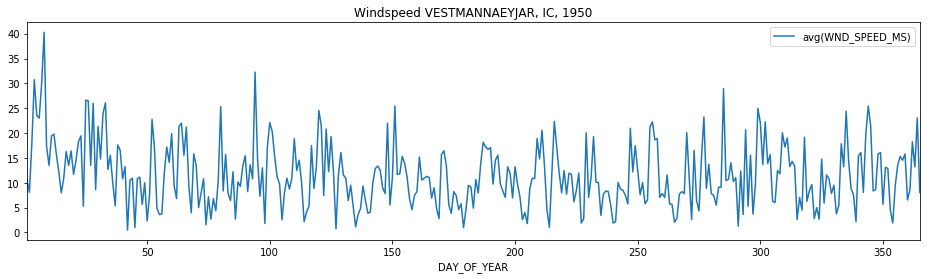

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

vestic_by_day_pdf = vestic_by_day.toPandas()
print(vestic_by_day_pdf)

vestic_by_day_pdf.plot(x='DAY_OF_YEAR', y='avg(WND_SPEED_MS)',
                       figsize=(16,4), title='Windspeed VESTMANNAEYJAR, IC, 1950')

In [26]:
vestic_by_day.write.format('csv').save('hdfs://192.168.2.87:9000/VESTMANNAEYJAR-1950-wind.csv')
# Have a look in the file explorer? where do all these files come from?

In [27]:
# To delete...
# ~/hadoop-2.7.7/bin/hdfs dfs -rm -r /VESTMANNAEYJAR-1950-wind.csv